# Implementing a Route Planner
In this project you will use A\* search to implement a "Google-maps" style route planning algorithm.

## The Map

In [33]:
# Run this cell first!

from helpers import Map, load_map_10, load_map_40, show_map
import math

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Map Basics

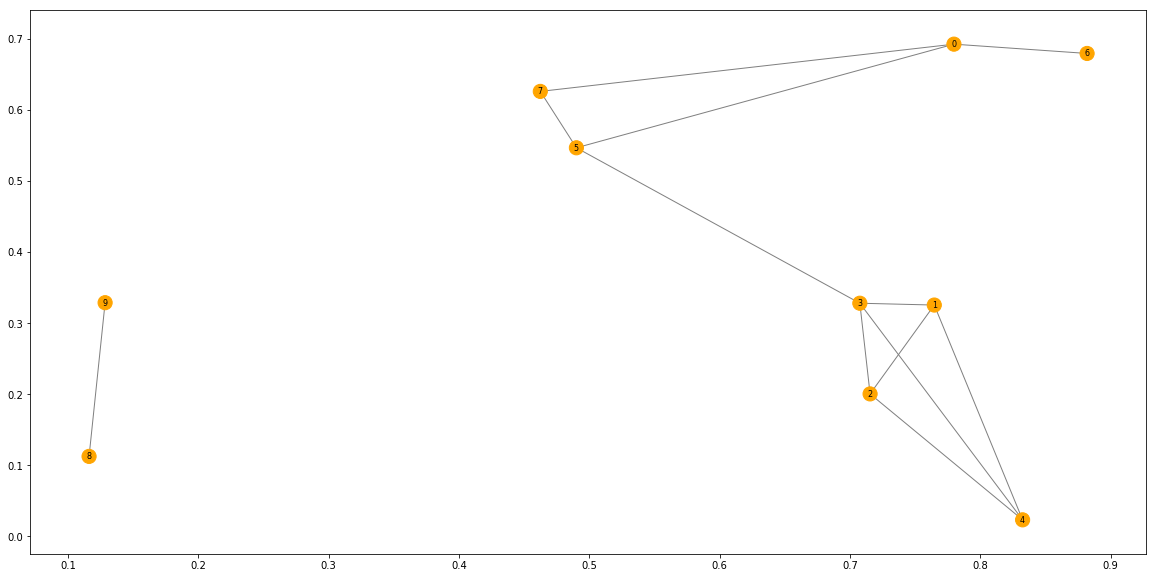

In [37]:
map_10 = load_map_10()
show_map(map_10)

The map above (run the code cell if you don't see it) shows a disconnected network of 10 intersections. The two intersections on the left are connected to each other but they are not connected to the rest of the road network. This map is quite literal in its expression of distance and connectivity. On the graph above, the edge between 2 nodes(intersections) represents a literal straight road not just an abstract connection of 2 cities.

These `Map` objects have two properties you will want to use to implement A\* search: `intersections` and `roads`

**Intersections**

The `intersections` are represented as a dictionary. 

In this example, there are 10 intersections, each identified by an x,y coordinate. The coordinates are listed below. You can hover over each dot in the map above to see the intersection number.

In [3]:
map_10.intersections

{0: (0.7798606835438107, 0.6922727646627362),
 1: (0.7647837074641568, 0.3252670836724646),
 2: (0.7155217893995438, 0.20026498027300055),
 3: (0.7076566826610747, 0.3278339270610988),
 4: (0.8325506249953353, 0.02310946309985762),
 5: (0.49016747075266875, 0.5464878695400415),
 6: (0.8820353070895344, 0.6791919587749445),
 7: (0.46247219371675075, 0.6258061621642713),
 8: (0.11622158839385677, 0.11236327488812581),
 9: (0.1285377678230034, 0.3285840695698353)}

**Roads**

The `roads` property is a list where `roads[i]` contains a list of the intersections that intersection `i` connects to.

In [4]:
# this shows that intersection 0 connects to intersections 7, 6, and 5
map_10.roads[0] 

[5, 6, 7]

In [5]:
# This shows the full connectivity of the map
map_10.roads

[[5, 6, 7],
 [2, 3, 4],
 [1, 3, 4],
 [1, 2, 4, 5],
 [1, 2, 3],
 [0, 3, 7],
 [0],
 [0, 5],
 [9],
 [8]]

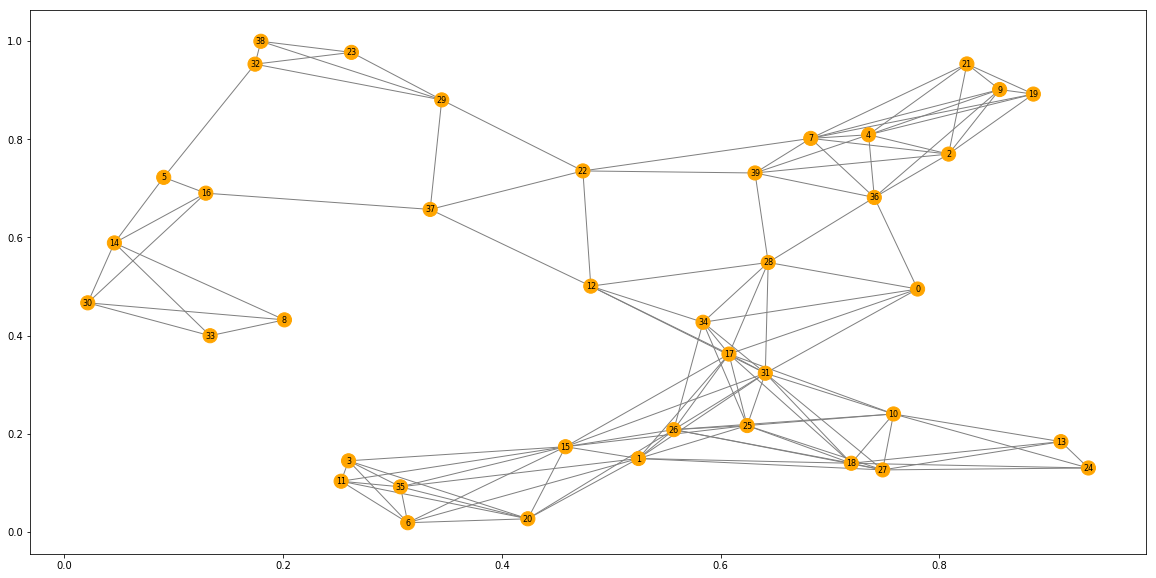

In [38]:
# map_40 is a bigger map than map_10
map_40 = load_map_40()
show_map(map_40)

### Advanced Visualizations

The map above shows a network of roads which spans 40 different intersections (labeled 0 through 39). 

The `show_map` function which generated this map also takes a few optional parameters which might be useful for visualizing the output of the search algorithm you will write.

* `start` - The "start" node for the search algorithm.
* `goal`  - The "goal" node.
* `path`  - An array of integers which corresponds to a valid sequence of intersection visits on the map.

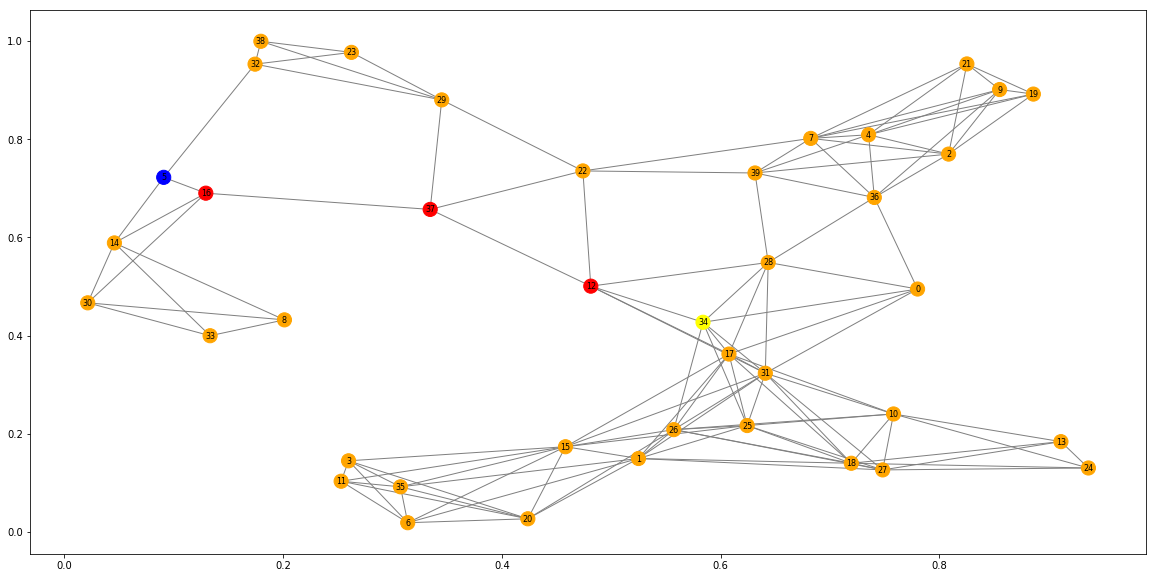

In [39]:
# run this code, note the effect of including the optional
# parameters in the function call.
show_map(map_40, start=5, goal=34, path=[5,16,37,12,34])

## The Algorithm
### Writing your algorithm
The algorithm written will be responsible for generating a `path` like the one passed into `show_map` above. In fact, when called with the same map, start and goal, as above you algorithm should produce the path `[5, 16, 37, 12, 34]`. However you must complete several methods before it will work.

```bash
> PathPlanner(map_40, 5, 34).path
[5, 16, 37, 12, 34]
```

### PathPlanner class

The below class is already partly implemented for you - you will implement additional functions that will also get included within this class further below.

Let's very briefly walk through each part below.

`__init__` - We initialize our path planner with a map, M, and typically a start and goal node. If either of these are `None`, the rest of the variables here are also set to none. If you don't have both a start and a goal, there's no path to plan! The rest of these variables come from functions you will soon implement. 
- `closedSet` includes any explored/visited nodes. 
- `openSet` are any nodes on our frontier for potential future exploration. 
- `cameFrom` will hold the previous node that best reaches a given node
- `gScore` is the `g` in our `f = g + h` equation, or the actual cost to reach our current node
- `fScore` is the combination of `g` and `h`, i.e. the `gScore` plus a heuristic; total cost to reach the goal
- `path` comes from the `run_search` function, which is already built for you.

`reconstruct_path` - This function just rebuilds the path after search is run, going from the goal node backwards using each node's `cameFrom` information.

`_reset` - Resets *most* of our initialized variables for PathPlanner. This *does not* reset the map, start or goal variables, for reasons which you may notice later, depending on your implementation.

`run_search` - This does a lot of the legwork to run search once you've implemented everything else below. First, it checks whether the map, goal and start have been added to the class. Then, it will also check if the other variables, other than `path` are initialized (note that these are only needed to be re-run if the goal or start were not originally given when initializing the class, based on what we discussed above for `__init__`.

From here, we use a function you will implement, `is_open_empty`, to check that there are still nodes to explore (you'll need to make sure to feed `openSet` the start node to make sure the algorithm doesn't immediately think there is nothing to open!). If we're at our goal, we reconstruct the path. If not, we move our current node from the frontier (`openSet`) and into explored (`closedSet`). Then, we check out the neighbors of the current node, check out their costs, and plan our next move.

This is the main idea behind A*, but none of it is going to work until you implement all the relevant parts, which will be included below after the class code.

In [8]:
# Do not change this cell
# When you write your methods correctly this cell will execute
# without problems
class PathPlanner():
    """Construct a PathPlanner Object"""
    def __init__(self, M, start=None, goal=None):
        """ """
        self.map = M
        self.start= start
        self.goal = goal
        self.closedSet = self.create_closedSet() if goal != None and start != None else None
        self.openSet = self.create_openSet() if goal != None and start != None else None
        self.cameFrom = self.create_cameFrom() if goal != None and start != None else None
        self.gScore = self.create_gScore() if goal != None and start != None else None
        self.fScore = self.create_fScore() if goal != None and start != None else None
        self.path = self.run_search() if self.map and self.start != None and self.goal != None else None
    
    def reconstruct_path(self, current):
        """ Reconstructs path after search """
        total_path = [current]
        while current in self.cameFrom.keys():
            current = self.cameFrom[current]
            total_path.append(current)
        return total_path
    
    def _reset(self):
        """Private method used to reset the closedSet, openSet, cameFrom, gScore, fScore, and path attributes"""
        self.closedSet = None
        self.openSet = None
        self.cameFrom = None
        self.gScore = None
        self.fScore = None
        self.path = self.run_search() if self.map and self.start and self.goal else None

    def run_search(self):
        """ """
        if self.map == None:
            raise(ValueError, "Must create map before running search. Try running PathPlanner.set_map(start_node)")
        if self.goal == None:
            raise(ValueError, "Must create goal node before running search. Try running PathPlanner.set_goal(start_node)")
        if self.start == None:
            raise(ValueError, "Must create start node before running search. Try running PathPlanner.set_start(start_node)")

        self.closedSet = self.closedSet if self.closedSet != None else self.create_closedSet()
        self.openSet = self.openSet if self.openSet != None else  self.create_openSet()
        self.cameFrom = self.cameFrom if self.cameFrom != None else  self.create_cameFrom()
        self.gScore = self.gScore if self.gScore != None else  self.create_gScore()
        self.fScore = self.fScore if self.fScore != None else  self.create_fScore()

        while not self.is_open_empty():
            current = self.get_current_node()

            if current == self.goal:
                self.path = [x for x in reversed(self.reconstruct_path(current))]
                return self.path
            else:
                self.openSet.remove(current)
                self.closedSet.add(current)

            for neighbor in self.get_neighbors(current):
                if neighbor in self.closedSet:
                    continue    # Ignore the neighbor which is already evaluated.

                if not neighbor in self.openSet:    # Discover a new node
                    self.openSet.add(neighbor)
                
                # The distance from start to a neighbor
                #the "dist_between" function may vary as per the solution requirements.
                if self.get_tentative_gScore(current, neighbor) >= self.get_gScore(neighbor):
                    continue        # This is not a better path.

                # This path is the best until now. Record it!
                self.record_best_path_to(current, neighbor)
        print("No Path Found")
        self.path = None
        return False

## Your Turn

Implement the following functions to get your search algorithm running smoothly!

### Data Structures

The next few functions requre you to decide on data structures to use - lists, sets, dictionaries, etc. Make sure to think about what would work most efficiently for each of these. Some can be returned as just an empty data structure (see `create_closedSet()` for an example), while others should be initialized with one or more values within.

In [9]:
def create_closedSet(self):
    """ Creates and returns a data structure suitable to hold the set of nodes already evaluated"""
    # EXAMPLE: return a data structure suitable to hold the set of nodes already evaluated
    return set()

In [10]:
def create_openSet(self):
    """ Creates and returns a data structure suitable to hold the set of currently discovered nodes 
    that are not evaluated yet. Initially, only the start node is known."""
    if self.start != None:
        # TODO: return a data structure suitable to hold the set of currently discovered nodes 
        # that are not evaluated yet. Make sure to include the start node.
        return set([self.start])
    
    raise(ValueError, "Must create start node before creating an open set. Try running PathPlanner.set_start(start_node)")

In [11]:
def create_cameFrom(self):
    """Creates and returns a data structure that shows which node can most efficiently be reached from another,
    for each node."""
    # TODO: return a data structure that shows which node can most efficiently be reached from another,
    # for each node. 
    return {}

In [12]:
def create_gScore(self):
    """Creates and returns a data structure that holds the cost of getting from the start node to that node, 
    for each node. The cost of going from start to start is zero."""
    # TODO:  return a data structure that holds the cost of getting from the start node to that node, for each node.
    # for each node. The cost of going from start to start is zero. The rest of the node's values should 
    # be set to infinity.
    gScore = {}
    for intersection in self.map.intersections:
        if intersection == self.start:
            gScore[intersection] = 0
        else:
            gScore[intersection] = float('inf') #math.inf
    
    return gScore   

In [28]:
def create_fScore(self):
    """Creates and returns a data structure that holds the total cost of getting from the start node to the goal
    by passing by that node, for each node. That value is partly known, partly heuristic.
    For the first node, that value is completely heuristic."""
    # TODO: return a data structure that holds the total cost of getting from the start node to the goal
    # by passing by that node, for each node. That value is partly known, partly heuristic.
    # For the first node, that value is completely heuristic. The rest of the node's value should be 
    # set to infinity.
    fScore = {}
    for intersection in self.map.intersections:
        if intersection == self.start:
            fScore[intersection] = self.distance(self.start, self.goal)
        else:
            fScore[intersection] = float('inf') #math.inf
    return fScore   


### Set certain variables

The below functions help set certain variables if they weren't a part of initializating our `PathPlanner` class, or if they need to be changed for anothe reason.

In [14]:
def set_map(self, M):
    """Method used to set map attribute """
    self._reset(self)
    self.start = None
    self.goal = None
    # TODO: Set map to new value. 
    self.M = M


In [15]:
def set_start(self, start):
    """Method used to set start attribute """
    self._reset(self)
    # TODO: Set start value. Remember to remove goal, closedSet, openSet, cameFrom, gScore, fScore, 
    # and path attributes' values.
    self.start = start
    self.goal = None
    self.closedSet = None
    self.openSet = None
    self.cameFrom = None
    self.gScore = None
    self.fScore = None
    self.path = None
    

In [16]:
def set_goal(self, goal):
    """Method used to set goal attribute """
    self._reset(self)
    # TODO: Set goal value. 
    self.goal = goal
    self.closedSet = self.create_closedSet()
    self.openSet = self.create_openSet()
    self.cameFrom = self.create_cameFrom()
    self.gScore = self.create_gScore()
    self.fScore = self.create_fScore()
    self.path = self.run_search()


### Get node information

The below functions concern grabbing certain node information. In `is_open_empty`, you are checking whether there are still nodes on the frontier to explore. In `get_current_node()`, you'll want to come up with a way to find the lowest `fScore` of the nodes on the frontier. In `get_neighbors`, you'll need to gather information from the map to find the neighbors of the current node.

In [17]:
def is_open_empty(self):
    """returns True if the open set is empty. False otherwise. """
    # TODO: Return True if the open set is empty. False otherwise.
    return (len(self.openSet) == 0)


In [18]:
def get_current_node(self):
    """ Returns the node in the open set with the lowest value of f(node)."""
    # TODO: Return the node in the open set with the lowest value of f(node).
    rsp = None
    for node in self.openSet:
        if rsp is None or self.fScore[node] < self.fScore[rsp]:
            rsp = node
    return rsp


In [19]:
def get_neighbors(self, node):
    """Returns the neighbors of a node"""
    # TODO: Return the neighbors of a node
    return self.map.roads[node]


### Scores and Costs

Below, you'll get into the main part of the calculation for determining the best path - calculating the various parts of the `fScore`.

In [20]:
def get_gScore(self, node):
    """Returns the g Score of a node"""
    # TODO: Return the g Score of a node
    return self.gScore[node]


In [21]:
def distance(self, node_1, node_2):
    """ Computes the Euclidean L2 Distance"""
    # TODO: Compute and return the Euclidean L2 Distance
    x1 = self.map.intersections[node_1][0]
    y1 = self.map.intersections[node_1][1]
    x2 = self.map.intersections[node_2][0]
    y2 = self.map.intersections[node_2][1]
    return math.sqrt(((x2 - x1)**2) + ((y2 - y1)**2))


In [22]:
def get_tentative_gScore(self, current, neighbor):
    """Returns the tentative g Score of a node"""
    # TODO: Return the g Score of the current node 
    # plus distance from the current node to it's neighbors
    return self.gScore[current] + self.distance(current, neighbor)


In [23]:
def heuristic_cost_estimate(self, node):
    """ Returns the heuristic cost estimate of a node """
    # TODO: Return the heuristic cost estimate of a node
    return self.distance(node, self.goal)


In [24]:
def calculate_fscore(self, node):
    """Calculate the f score of a node. """
    # TODO: Calculate and returns the f score of a node. 
    # REMEMBER F = G + H
    return self.gScore[node] + self.heuristic_cost_estimate(node)
    

### Recording the best path

Now that you've implemented the various functions on scoring, you can record the best path to a given neighbor node from the current node!

In [25]:
def record_best_path_to(self, current, neighbor):
    """Record the best path to a node """
    # TODO: Record the best path to a node, by updating cameFrom, gScore, and fScore
    self.cameFrom[neighbor] = current
    self.gScore[neighbor] = self.gScore[current] + self.distance(current, neighbor)
    self.fScore[neighbor] = self.gScore[neighbor] + self.heuristic_cost_estimate(neighbor)

### Associating your functions with the `PathPlanner` class

To check your implementations, we want to associate all of the above functions back to the `PathPlanner` class. Python makes this easy using the dot notation (i.e. `PathPlanner.myFunction`), and setting them equal to your function implementations. Run the below code cell for this to occur.

*Note*: If you need to make further updates to your functions above, you'll need to re-run this code cell to associate the newly updated function back with the `PathPlanner` class again!

In [29]:
# Associates implemented functions with PathPlanner class
PathPlanner.create_closedSet = create_closedSet
PathPlanner.create_openSet = create_openSet
PathPlanner.create_cameFrom = create_cameFrom
PathPlanner.create_gScore = create_gScore
PathPlanner.create_fScore = create_fScore
PathPlanner.set_map = set_map
PathPlanner.set_start = set_start
PathPlanner.set_goal = set_goal
PathPlanner.is_open_empty = is_open_empty
PathPlanner.get_current_node = get_current_node
PathPlanner.get_neighbors = get_neighbors
PathPlanner.get_gScore = get_gScore
PathPlanner.distance = distance
PathPlanner.get_tentative_gScore = get_tentative_gScore
PathPlanner.heuristic_cost_estimate = heuristic_cost_estimate
PathPlanner.calculate_fscore = calculate_fscore
PathPlanner.record_best_path_to = record_best_path_to

### Preliminary Test

The below is the first test case, just based off of one set of inputs. If some of the functions above aren't implemented yet, or are implemented incorrectly, you likely will get an error from running this cell. Try debugging the error to help you figure out what needs further revision!

In [30]:
planner = PathPlanner(map_40, 5, 34)
path = planner.path
if path == [5, 16, 37, 12, 34]:
    print("great! Your code works for these inputs!")
else:
    print("something is off, your code produced the following:")
    print(path)

great! Your code works for these inputs!


#### Visualize

Once the above code worked for you, let's visualize the results of your algorithm!

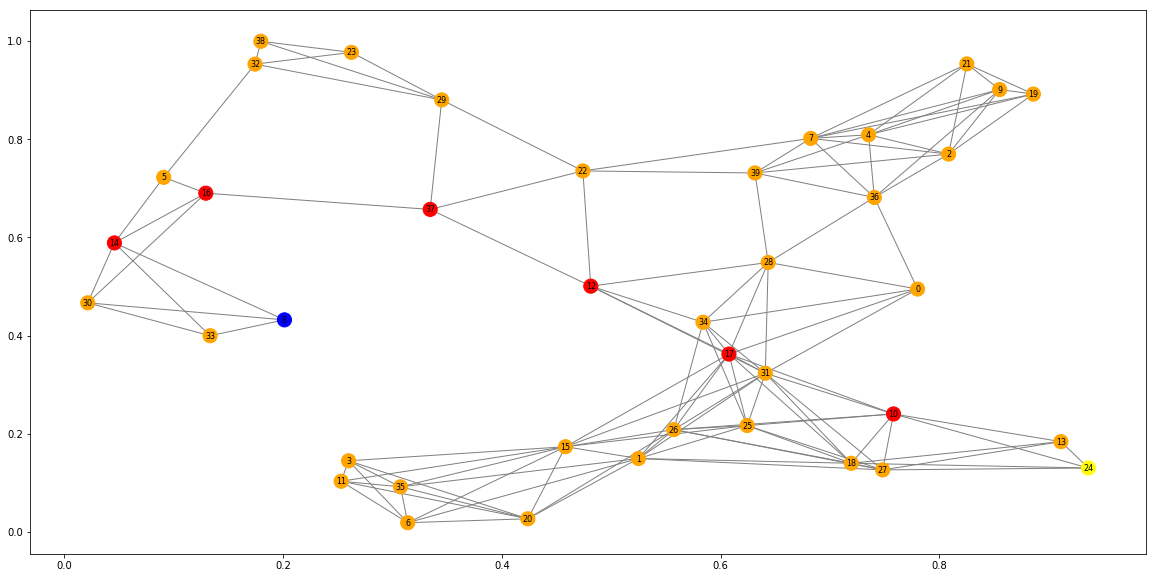

In [40]:
# Visualize your the result of the above test! You can also change start and goal here to check other paths
start = 8
goal = 24

show_map(map_40, start=start, goal=goal, path=PathPlanner(map_40, start, goal).path)

---